# Protein Ligand Complex MD Setup tutorial using BioExcel Building Blocks (biobb)
### Based on the official Gromacs tutorial: http://www.mdtutorials.com/gmx/complex/index.html
***
This tutorial aims to illustrate the process of **setting up a simulation system** containing a **protein in complex with a ligand**, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **T4 lysozyme** L99A/M102Q protein (PDB code 3HTB), in complex with the **2-propylphenol** small molecule (3-letter Code JZ4). 
***
**Biobb modules** used:

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_model](https://github.com/bioexcel/biobb_model): Tools to model macromolecular structures.
 - [biobb_chemistry](https://github.com/bioexcel/biobb_chemistry): Tools to manipulate chemical data.
 - [biobb_md](https://github.com/bioexcel/biobb_md): Tools to setup and run Molecular Dynamics simulations.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 - [biobb_structure_utils](https://github.com/bioexcel/biobb_structure_utils):  Tools to modify or extract information from a PDB structure file.
 
**Auxiliar libraries** used:

 - [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
 - [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.
 - [os](https://docs.python.org/3/library/os.html): Python miscellaneous operating system interfaces
 - [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
 - [simpletraj](https://github.com/arose/simpletraj): Lightweight coordinate-only trajectory reader based on code from GROMACS, MDAnalysis and VMD.


### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_protein-complex_md_setup.git
cd biobb_wf_protein-complex_md_setup
conda env create -f conda_env/environment.yml
conda activate biobb_Protein-Complex_MDsetup_tutorial
jupyter-nbextension enable --py --user widgetsnbextension
jupyter-nbextension enable --py --user nglview
jupyter-notebook biobb_wf_protein-complex_md_setup/notebooks/biobb_Protein-Complex_MDsetup_tutorial.ipynb
  ``` 

***
### Pipeline steps:
 1. [Input Parameters](#input)
 2. [Fetching PDB Structure](#fetch)
 3. [Fix Protein Structure](#fix)
 4. [Create Protein System Topology](#top)
 5. [Create ligand system topology](#ligtop)
 6. [Preparing Ligand Restraints](#restraints)
 7. [Create new protein-ligand complex structure file](#complex)
 8. [Create new protein-ligand complex topology file](#complextop)
 9. [Create Solvent Box](#box)
 10. [Fill the Box with Water Molecules](#water)
 11. [Adding Ions](#ions)
 12. [Energetically Minimize the System](#min)
 13. [Equilibrate the System (NVT)](#nvt)
 14. [Equilibrate the System (NPT)](#npt)
 15. [Free Molecular Dynamics Simulation](#free)
 16. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 17. [Output Files](#output)
 18. [Questions & Comments](#questions)
 
***
 ***
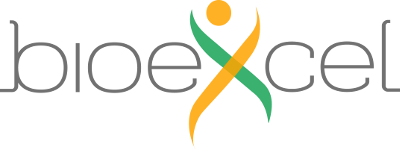
***

<a id="input"></a>
## Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein-ligand complex structure (e.g. 3HTB)
 - **ligandCode**: Small molecule 3-letter code for the ligand structure (e.g. JZ4)
 - **mol_charge**: Charge of the small molecule, needed to add hydrogen atoms.

In [1]:
import nglview
import ipywidgets
import os
import zipfile

pdbCode = "3HTB"
ligandCode = "JZ4"
mol_charge = 0

<a id="fetch"></a>
***
## Fetching PDB structure
Downloading **PDB structure** with the **protein-ligand complex** from the RCSB PDB database.<br>
Alternatively, a PDB file can be used as starting structure. <br>
Splitting the molecule in **three different files**: 
- **proteinFile**: Protein structure
- **ligandFile**: Ligand structure
- **complexFile**: Protein-ligand complex structure 

***
**Building Blocks** used:
 - [Pdb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.pdb) from **biobb_io.api.pdb**
***

In [ ]:
# Downloading desired PDB file 
# Import module
from biobb_io.api.pdb import Pdb

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode+'.orig.pdb'
prop = {
    'pdb_code': pdbCode,
    'filter': False
}

# Create and launch bb
Pdb(output_pdb_path=downloaded_pdb,
    properties=prop).launch()

In [ ]:
# Extracting Protein, Ligand and Protein-Ligand Complex to three different files
# Import module
from biobb_structure_utils.utils.extract_heteroatoms import ExtractHeteroAtoms
from biobb_structure_utils.utils.extract_protein import ExtractProtein
from biobb_structure_utils.utils.cat_pdb import CatPDB

# Create properties dict and inputs/outputs
proteinFile = pdbCode+'.pdb'
ligandFile = ligandCode+'.pdb'
complexFile = pdbCode+'_'+ligandCode+'.pdb'

prop = {
     'heteroatoms' : [{"name": "JZ4"}]
}

ExtractHeteroAtoms(input_structure_path=downloaded_pdb,
     output_heteroatom_path=ligandFile,
     properties=prop).launch()

ExtractProtein(input_structure_path=downloaded_pdb,
     output_protein_path=proteinFile).launch()

CatPDB(input_structure1=proteinFile,
       input_structure2=ligandFile,
       output_structure_path=complexFile).launch()

### Visualizing 3D structures
Visualizing the generated **PDB structures** using **NGL**:  
- **Protein structure** (Left)
- **Ligand structure** (Center)
- **Protein-ligand complex** (Right)  

In [45]:
# Show structures: protein, ligand and protein-ligand complex
view1 = nglview.show_structure_file(proteinFile)
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(ligandFile)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(complexFile)
view3.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

In [46]:
view1.render_image()
view1.download_image(filename='ngl1.png')
view2.render_image()
view2.download_image(filename='ngl2.png')
view3.render_image()
view3.download_image(filename='ngl3.png')

<img style='float:left;width:33%' src='ngl1.png'></img><img style='float:left;width:33%' src='ngl2.png'></img><img style='float:left;width:33%' src='ngl3.png'></img>

<a id="fix"></a>
***
## Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**Building Blocks** used:
 - [FixSideChain](https://biobb-model.readthedocs.io/en/latest/model.html#module-model.fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [ ]:
# Check & Fix Protein Structure
# Import module
from biobb_model.model.fix_side_chain import FixSideChain

# Create prop dict and inputs/outputs
fixed_pdb = pdbCode+'_fixed.pdb'

# Create and launch bb
FixSideChain(input_pdb_path=proteinFile,
             output_pdb_path=fixed_pdb).launch()

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_md.gromacs.pdb2gmx**
***

In [ ]:
# Create Protein system topology
# Import module
from biobb_md.gromacs.pdb2gmx import Pdb2gmx

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode+'_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode+'_pdb2gmx_top.zip'
prop = {
    'force_field' : 'amber99sb-ildn',
    'water_type': 'spce'
}

# Create and launch bb
Pdb2gmx(input_pdb_path=fixed_pdb,
        output_gro_path=output_pdb2gmx_gro,
        output_top_zip_path=output_pdb2gmx_top_zip,
        properties=prop).launch()

<a id="ligtop"></a>
***
## Create ligand system topology
**Building GROMACS topology** corresponding to the ligand structure.<br>
Force field used in this tutorial step is **amberGAFF**: [General AMBER Force Field](http://ambermd.org/antechamber/gaff.html), designed for rational drug design.<br>
- [Step 1](#ligandTopologyStep1): Add **hydrogen atoms** if missing.
- [Step 2](#ligandTopologyStep2): **Energetically minimize the system** with the new hydrogen atoms. 
- [Step 3](#ligandTopologyStep3): Generate **ligand topology** (parameters). 
***
**Building Blocks** used:
 - [ReduceAddHydrogens](https://biobb-chemistry.readthedocs.io/en/latest/ambertools.html#module-ambertools.reduce_add_hydrogens) from **biobb_chemistry.ambertools.reduce_add_hydrogens**
 - [BabelMinimize](https://biobb-chemistry.readthedocs.io/en/latest/babelm.html#module-babelm.babel_minimize) from **biobb_chemistry.babelm.babel_minimize** 
 - [AcpypeParamsGMX](https://biobb-chemistry.readthedocs.io/en/latest/acpype.html#module-acpype.acpype_params_gmx) from **biobb_chemistry.acpype.acpype_params_gmx** 
***

<a id="ligandTopologyStep1"></a>
### Step 1: Add **hydrogen atoms**

In [ ]:
# Create Ligand system topology, STEP 1
# Reduce_add_hydrogens: add Hydrogen atoms to a small molecule (using Reduce tool from Ambertools package)
# Import module
from biobb_chemistry.ambertools.reduce_add_hydrogens import ReduceAddHydrogens

# Create prop dict and inputs/outputs
output_reduce_h = ligandCode+'.reduce.H.pdb' 
prop = {
    'nuclear' : 'true'
}

# Create and launch bb
ReduceAddHydrogens(input_path=ligandFile,
                   output_path=output_reduce_h,
                   properties=prop).launch()


<a id="ligandTopologyStep2"></a>
### Step 2: **Energetically minimize the system** with the new hydrogen atoms. 

In [ ]:
# Create Ligand system topology, STEP 2
# Babel_minimize: Structure energy minimization of a small molecule after being modified adding hydrogen atoms
# Import module
from biobb_chemistry.babelm.babel_minimize import BabelMinimize

# Create prop dict and inputs/outputs
output_babel_min = ligandCode+'.H.min.mol2'                              
prop = {
    'method' : 'sd',
    'criteria' : '1e-10',
    'force_field' : 'GAFF'
}


# Create and launch bb
BabelMinimize(input_path=output_reduce_h,
              output_path=output_babel_min,
              properties=prop).launch()

### Visualizing 3D structures
Visualizing the small molecule generated **PDB structures** using **NGL**:  
- **Original Ligand Structure** (Left)
- **Ligand Structure with hydrogen atoms added** (with Reduce program) (Center)
- **Ligand Structure with hydrogen atoms added** (with Reduce program), **energy minimized** (with Open Babel) (Right) 

In [9]:
# Show different structures generated (for comparison)

view1 = nglview.show_structure_file(ligandFile)
view1.add_representation(repr_type='ball+stick')
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(output_reduce_h)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(output_babel_min)
view3.add_representation(repr_type='ball+stick')
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

In [ ]:
view1.render_image()
view1.download_image(filename='ngl4.png')
view2.render_image()
view2.download_image(filename='ngl5.png')
view3.render_image()
view3.download_image(filename='ngl6.png')

<img style='float:left;width:33%' src='ngl4.png'></img><img style='float:left;width:33%' src='ngl5.png'></img><img style='float:left;width:33%' src='ngl6.png'></img>

<a id="ligandTopologyStep3"></a>
### Step 3: Generate **ligand topology** (parameters).

In [ ]:
# Create Ligand system topology, STEP 3
# Acpype_params_gmx: Generation of topologies for GROMACS with ACPype
# Import module
from biobb_chemistry.acpype.acpype_params_gmx import AcpypeParamsGMX

# Create prop dict and inputs/outputs
output_acpype_gro = ligandCode+'params.gro'
output_acpype_itp = ligandCode+'params.itp'
output_acpype_top = ligandCode+'params.top'
output_acpype = ligandCode+'params'
prop = {
    'basename' : output_acpype,
    'charge' : mol_charge
}

# Create and launch bb
AcpypeParamsGMX(input_path=output_babel_min, 
                output_path_gro=output_acpype_gro,
                output_path_itp=output_acpype_itp,
                output_path_top=output_acpype_top,
                properties=prop).launch()

<a id="restraints"></a>
***
## Preparing Ligand Restraints
In subsequent steps of the pipeline, such as the equilibration stages of the **protein-ligand complex** system, it is recommended to apply some **restraints** to the small molecule, to avoid a possible change in position due to protein repulsion. **Position restraints** will be applied to the ligand, using a **force constant of 1000 KJ/mol\*nm^2** on the three coordinates: x, y and z. In this steps the **restriction files** will be created and integrated in the **ligand topology**.
- [Step 1](#restraintsStep1): Creating an index file with a new group including just the **small molecule heavy atoms**.
- [Step 2](#restraintsStep2): Generating the **position restraints** file.
***
**Building Blocks** used:
 - [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_md.gromacs.make_ndx** 
 - [Genrestr](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genrestr) from **biobb_md.gromacs.genrestr** 
***

<a id="restraintsStep1"></a>
### Step 1: Creating an index file for the small molecule heavy atoms

In [ ]:
# MakeNdx: Creating index file with a new group (small molecule heavy atoms)
from biobb_md.gromacs.make_ndx import MakeNdx

# Create prop dict and inputs/outputs
output_ligand_ndx = ligandCode+'_index.ndx'
prop = {
    'selection': "0 & ! a H*"
}

# Create and launch bb
MakeNdx(input_structure_path=output_acpype_gro,
        output_ndx_path=output_ligand_ndx,
        properties=prop).launch()

<a id="restraintsStep2"></a>
### Step 2: Generating the position restraints file

In [ ]:
# Genrestr: Generating the position restraints file
from biobb_md.gromacs.genrestr import Genrestr

# Create prop dict and inputs/outputs
output_restraints_top = ligandCode+'_posres.itp'
prop = {
    'force_constants': "1000 1000 1000",
    'restrained_group': "System"
}

# Create and launch bb
Genrestr(input_structure_path=output_acpype_gro,
         input_ndx_path=output_ligand_ndx,
         output_itp_path=output_restraints_top,
         properties=prop).launch()

<a id="complex"></a>
***
## Create new protein-ligand complex structure file
Building new **protein-ligand complex** PDB file with:
- The new **protein system** with fixed problems from *Fix Protein Structure* step and hydrogens atoms added from *Create Protein System Topology* step.
- The new **ligand system** with hydrogens atoms added from *Create Ligand System Topology* step. 

This new structure is needed for **GROMACS** as it is **force field-compliant**, it **has all the new hydrogen atoms**, and the **atom names are matching the newly generated protein and ligand topologies**.
***
**Building Blocks** used:
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str**
***

In [ ]:
# biobb analysis module
from biobb_analysis.gromacs.gmx_trjconv_str import GMXTrjConvStr
from biobb_structure_utils.utils.cat_pdb import CatPDB

# Convert gro (with hydrogens) to pdb (PROTEIN)
proteinFile_H = pdbCode+'_'+ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_pdb2gmx_gro,
              input_top_path=output_pdb2gmx_gro,
              output_str_path=proteinFile_H, 
              properties=prop).launch()

# Convert gro (with hydrogens) to pdb (LIGAND)
ligandFile_H = ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_acpype_gro,
              input_top_path=output_acpype_gro,
              output_str_path=ligandFile_H, 
              properties=prop).launch()


# Concatenating both PDB files: Protein + Ligand
complexFile_H = pdbCode+'_'+ligandCode+'_H.pdb'

# Create and launch bb
CatPDB(input_structure1=proteinFile_H,
       input_structure2=ligandFile_H,
       output_structure_path=complexFile_H).launch()

<a id="complextop"></a>
***
## Create new protein-ligand complex topology file
Building new **protein-ligand complex** GROMACS topology file with:
- The new **protein system** topology generated from *Create Protein System Topology* step.
- The new **ligand system** topology generated from *Create Ligand System Topology* step. 

NOTE: From this point on, the **protein-ligand complex structure and topology** generated can be used in a regular MD setup.
***
**Building Blocks** used:
 - [AppendLigand](https://biobb-md.readthedocs.io/en/latest/modules.html) from **biobb_md.gromacs_extra.append_ligand**  (NOTE: link should be updated with the documentation)
***

In [ ]:
# AppendLigand: Append a ligand to a GROMACS topology
# Import module
from biobb_md.gromacs_extra.append_ligand import AppendLigand

# Create prop dict and inputs/outputs
output_complex_top = pdbCode+'_'+ligandCode+'_complex.top.zip'

posresifdef = "POSRES_"+ligandCode.upper()
prop = {
    'posres_name': posresifdef
}

# Create and launch bb
AppendLigand(input_top_zip_path=output_pdb2gmx_top_zip,
             input_posres_itp_path=output_restraints_top,
             input_itp_path=output_acpype_itp, 
             output_top_zip_path=output_complex_top,
             properties=prop).launch()

<a id="box"></a>
***
## Create solvent box
Define the unit cell for the **protein-ligand complex** to fill it with water molecules.<br>
**Truncated octahedron** box is used for the unit cell. This box type is the one which best reflects the geometry of the solute/protein, in this case a **globular protein**, as it approximates a sphere. It is also convenient for the computational point of view, as it accumulates **less water molecules at the corners**, reducing the final number of water molecules in the system and making the simulation run faster.<br> A **protein to box** distance of **0.8 nm** is used, and the protein is **centered in the box**.  

***
**Building Blocks** used:
 - [Editconf](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.editconf) from **biobb_md.gromacs.editconf** 
***

In [ ]:
# Editconf: Create solvent box
# Import module
from biobb_md.gromacs.editconf import Editconf

# Create prop dict and inputs/outputs
output_editconf_gro = pdbCode+'_'+ligandCode+'_complex_editconf.gro'

prop = {
    'box_type': 'octahedron',
    'distance_to_molecule': 0.8
}

# Create and launch bb
Editconf(input_gro_path=complexFile_H, 
         output_gro_path=output_editconf_gro,
         properties=prop).launch()

<a id="water"></a>
***
## Fill the box with water molecules
Fill the unit cell for the **protein-ligand complex** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**Building Blocks** used:
 - [Solvate](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.solvate) from **biobb_md.gromacs.solvate** 
***

In [ ]:
# Solvate: Fill the box with water molecules
from biobb_md.gromacs.solvate import Solvate

# Create prop dict and inputs/outputs
output_solvate_gro = pdbCode+'_'+ligandCode+'_solvate.gro'
output_solvate_top_zip = pdbCode+'_'+ligandCode+'_solvate_top.zip'

# Create and launch bb
Solvate(input_solute_gro_path=output_editconf_gro,
        output_gro_path=output_solvate_gro,
        input_top_zip_path=output_complex_top,
        output_top_zip_path=output_solvate_top_zip).launch()

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **solvent box** using **NGL**<br>
Note the **octahedral box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the box.

In [17]:
#Show protein
view = nglview.show_structure_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='line', linewidth='1', selection='SOL', opacity='.3')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

In [ ]:
view.render_image()
view.download_image(filename='ngl7.png')

<img src='ngl7.png'></img>

<a id="ions"></a>
***
## Adding ions
Add ions to neutralize the **protein-ligand complex** and reach a desired ionic concentration.
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system and reach a **0.05 molar ionic concentration**
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Genion](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genion) from **biobb_md.gromacs.genion** 
***

<a id="ionsStep1"></a>
### Step 1: Creating portable binary run file for ion generation

In [ ]:
# Grompp: Creating portable binary run file for ion generation
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'type': 'minimization',
        'nsteps':'5000'
    }
}
output_gppion_tpr = pdbCode+'_'+ligandCode+'_complex_gppion.tpr'

# Create and launch bb
Grompp(input_gro_path=output_solvate_gro,
       input_top_zip_path=output_solvate_top_zip, 
       output_tpr_path=output_gppion_tpr,
       properties=prop).launch()

<a id="ionsStep2"></a>
### Step 2: Adding ions to neutralize the system and reach a 0.05 molar concentration
Replace **solvent molecules** with **ions** to **neutralize** the system and reaching a **0.05 molar ionic concentration**

In [ ]:
# Genion: Adding ions to reach a 0.05 molar concentration
from biobb_md.gromacs.genion import Genion

# Create prop dict and inputs/outputs
prop={
    'neutral':True,
    'concentration':0.05
}
output_genion_gro = pdbCode+'_'+ligandCode+'_genion.gro'
output_genion_top_zip = pdbCode+'_'+ligandCode+'_genion_top.zip'

# Create and launch bb
Genion(input_tpr_path=output_gppion_tpr,
       output_gro_path=output_genion_gro, 
       input_top_zip_path=output_solvate_top_zip,
       output_top_zip_path=output_genion_top_zip, 
       properties=prop).launch()

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **ionic concentration** using **NGL**

In [20]:
#Show protein
view = nglview.show_structure_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

In [ ]:
view.render_image()
view.download_image(filename='ngl8.png')

<img src='ngl8.png'></img>

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **protein-ligand complex** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **protein-ligand complex** till reaching a force of 500 kJ mol-1 nm-1.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization
Method used to run the **energy minimization** is a **steepest descent**, with a **maximum force of 500 KJ/mol\*nm^2**, and a minimization **step size of 1fs**. The **maximum number of steps** to perform if the maximum force is not reached is **5,000 steps**. 

In [ ]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'type': 'minimization',
        'nsteps':'5000',
        'emstep': 0.01,
        'emtol':'500'
    }
}
output_gppmin_tpr = pdbCode+'_'+ligandCode+'_gppmin.tpr'

# Create and launch bb
Grompp(input_gro_path=output_genion_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmin_tpr,
       properties=prop).launch()

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step.

In [ ]:
# Mdrun: Running minimization
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_min_trr = pdbCode+'_'+ligandCode+'_min.trr'
output_min_gro = pdbCode+'_'+ligandCode+'_min.gro'
output_min_edr = pdbCode+'_'+ligandCode+'_min.edr'
output_min_log = pdbCode+'_'+ligandCode+'_min.log'

# Create and launch bb
Mdrun(input_tpr_path=output_gppmin_tpr,
      output_trr_path=output_min_trr, 
      output_gro_path=output_min_gro,
      output_edr_path=output_min_edr, 
      output_log_path=output_min_log).launch()

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [ ]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode+'_'+ligandCode+'_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop).launch()

In [24]:
import plotly
import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open(output_min_ene_xvg,'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
})

plotly.offline.iplot(fig)

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein-ligand complex** system in NVT ensemble (constant Number of particles, Volume and Temperature). To avoid temperature coupling problems, a new *"system"* group will be created including the **protein** + the **ligand** to be assigned to a single thermostatting group.

- [Step 1](#eqNVTStep1): Creating an index file with a new group including the **protein-ligand complex**.
- [Step 2](#eqNVTStep3): Creating portable binary run file for system equilibration
- [Step 3](#eqNVTStep3): Equilibrate the **protein-ligand complex** with NVT ensemble.
- [Step 4](#eqNVTStep4): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process. 
***
**Building Blocks** used:
- [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_md.gromacs.make_ndx** 
- [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
- [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
- [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNVTStep1"></a>
### Step 1: Creating an index file with a new group including the **protein-ligand complex**

In [ ]:
# MakeNdx: Creating index file with a new group (protein-ligand complex)
from biobb_md.gromacs.make_ndx import MakeNdx

# Create prop dict and inputs/outputs
output_complex_ndx = pdbCode+'_'+ligandCode+'_index.ndx'
prop = {
    'selection': "\"Protein\"|\"Other\"" 
}

# Create and launch bb
MakeNdx(input_structure_path=output_min_gro,
        output_ndx_path=output_complex_ndx,
        properties=prop).launch()

<a id="eqNVTStep2"></a>
### Step 2: Creating portable binary run file for system equilibration (NVT)
Note that for the purposes of temperature coupling, the **protein-ligand complex** (*Protein_Other*) is considered as a single entity.

In [ ]:
# Grompp: Creating portable binary run file for NVT System Equilibration
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode+'_'+ligandCode+'gppnvt.tpr'
prop = {
    'mdp':{
        'type': 'nvt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'define': '-DPOSRES -D' + posresifdef
    }
}

# Create and launch bb
Grompp(input_gro_path=output_min_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnvt_tpr,
       properties=prop).launch()

<a id="eqNVTStep3"></a>
### Step 3: Running NVT equilibration

In [ ]:
# Mdrun: Running NVT System Equilibration 
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_nvt_trr = pdbCode+'_'+ligandCode+'_nvt.trr'
output_nvt_gro = pdbCode+'_'+ligandCode+'_nvt.gro'
output_nvt_edr = pdbCode+'_'+ligandCode+'_nvt.edr'
output_nvt_log = pdbCode+'_'+ligandCode+'_nvt.log'
output_nvt_cpt = pdbCode+'_'+ligandCode+'_nvt.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppnvt_tpr,
      output_trr_path=output_nvt_trr,
      output_gro_path=output_nvt_gro,
      output_edr_path=output_nvt_edr,
      output_log_path=output_nvt_log,
      output_cpt_path=output_nvt_cpt).launch()

<a id="eqNVTStep4"></a>
### Step 4: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [ ]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode+'_'+ligandCode+'_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_nvt_edr, 
          output_xvg_path=output_nvt_temp_xvg, 
          properties=prop).launch()

In [29]:
import plotly
import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg,'r') as temperature_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in temperature_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Temperature during NVT Equilibration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Temperature (K)")
                       )
})

plotly.offline.iplot(fig)

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein-ligand complex** system in NPT ensemble (constant Number of particles, Pressure and Temperature) .
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein-ligand complex** with NPT ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

In [ ]:
# Grompp: Creating portable binary run file for (NPT) System Equilibration
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode+'_'+ligandCode+'_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'define': '-DPOSRES -D' + posresifdef
    }
}

# Create and launch bb
Grompp(input_gro_path=output_nvt_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnpt_tpr,
       input_cpt_path=output_nvt_cpt,
       properties=prop).launch()


<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [ ]:
# Mdrun: Running NPT System Equilibration
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_'+ligandCode+'_npt.trr'
output_npt_gro = pdbCode+'_'+ligandCode+'_npt.gro'
output_npt_edr = pdbCode+'_'+ligandCode+'_npt.edr'
output_npt_log = pdbCode+'_'+ligandCode+'_npt.log'
output_npt_cpt = pdbCode+'_'+ligandCode+'_npt.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppnpt_tpr,
      output_trr_path=output_npt_trr,
      output_gro_path=output_npt_gro,
      output_edr_path=output_npt_edr,
      output_log_path=output_npt_log,
      output_cpt_path=output_npt_cpt).launch()

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [ ]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_'+ligandCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop).launch()

In [33]:
import plotly
from plotly import subplots
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

/anaconda3/envs/biobb_dev/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein-ligand complex** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein-ligand complex**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXRms](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rms) from **biobb_analysis.gromacs.gmx_rms** 
 - [GMXRgyr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr** 
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free MD simulation

In [ ]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'type': 'free',
        #'nsteps':'500000' # 1 ns (500,000 steps x 2fs per step)
        #'nsteps':'5000' # 10 ps (5,000 steps x 2fs per step)
        'nsteps':'25000' # 50 ps (25,000 steps x 2fs per step)
    }
}
output_gppmd_tpr = pdbCode+'_'+ligandCode + '_gppmd.tpr'

# Create and launch bb
Grompp(input_gro_path=output_npt_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmd_tpr,
       input_cpt_path=output_npt_cpt,
       properties=prop).launch()

<a id="mdStep2"></a>
### Step 2: Running short free MD simulation

In [ ]:
# Mdrun: Running free dynamics
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_md_trr = pdbCode+'_'+ligandCode+'_md.trr'
output_md_gro = pdbCode+'_'+ligandCode+'_md.gro'
output_md_edr = pdbCode+'_'+ligandCode+'_md.edr'
output_md_log = pdbCode+'_'+ligandCode+'_md.log'
output_md_cpt = pdbCode+'_'+ligandCode+'_md.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppmd_tpr,
      output_trr_path=output_md_trr,
      output_gro_path=output_md_gro,
      output_edr_path=output_md_edr,
      output_log_path=output_md_log,
      output_cpt_path=output_md_cpt).launch()

<a id="mdStep3"></a>
### Step 3: Checking free MD simulation results
Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [ ]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against minimized and equilibrated snapshot (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import GMXRms

# Create prop dict and inputs/outputs
output_rms_first = pdbCode+'_'+ligandCode+'_rms_first.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmd_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_first, 
          properties=prop).launch()

In [ ]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against experimental structure (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import GMXRms

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode+'_'+ligandCode+'_rms_exp.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_exp, 
          properties=prop).launch()

In [38]:
import plotly
import plotly.graph_objs as go

# Read RMS vs first snapshot data from file 
with open(output_rms_first,'r') as rms_first_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_first_file 
            if not line.startswith(("#","@")) 
        ])
    )

# Read RMS vs experimental structure data from file 
with open(output_rms_exp,'r') as rms_exp_file:
    x2,y2 = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_exp_file
            if not line.startswith(("#","@")) 
        ])
    )
    
trace1 = go.Scatter(
    x = x,
    y = y,
    name = 'RMSd vs first'
)

trace2 = go.Scatter(
    x = x,
    y = y2,
    name = 'RMSd vs exp'
)

data = [trace1, trace2]

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": data,
    "layout": go.Layout(title="RMSd during free MD Simulation",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "RMSd (nm)")
                       )
})

plotly.offline.iplot(fig)

In [ ]:
# GMXRgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

from biobb_analysis.gromacs.gmx_rgyr import GMXRgyr

# Create prop dict and inputs/outputs
output_rgyr = pdbCode+'_'+ligandCode+'_rgyr.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRgyr(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rgyr, 
          properties=prop).launch()

In [40]:
import plotly
import plotly.graph_objs as go

# Read Rgyr data from file 
with open(output_rgyr,'r') as rgyr_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rgyr_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Radius of Gyration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Rgyr (nm)")
                       )
})

plotly.offline.iplot(fig)

<a id="post"></a>
***
## Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein-ligand complex system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep2): Generating a *dry* structure, **removing water molecules and ions** from the final snapshot of the MD setup pipeline.
- [Step 3](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**Building Blocks** used:
 - [GMXImage](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_image) from **biobb_analysis.gromacs.gmx_image** 
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str** 
***

<a id="ppStep1"></a>
### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [ ]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure
from biobb_analysis.gromacs.gmx_image import GMXImage

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode+'_imaged_traj.trr'
prop = {
    'center_selection':  'Protein_Other',
    'output_selection': 'Protein_Other',
    'pbc' : 'mol',
    'center' : True
}

# Create and launch bb
GMXImage(input_traj_path=output_md_trr,
         input_top_path=output_gppmd_tpr,
         input_index_path=output_complex_ndx,
         output_traj_path=output_imaged_traj, 
          properties=prop).launch()

<a id="ppStep2"></a>
### Step 2: Generating the output *dry* structure.
**Removing water molecules and ions** from the resulting structure

In [ ]:
# GMXTrjConvStr: Converting and/or manipulating a structure
#                Removing water molecules and ions from the resulting structure
#                The "dry" structure will be used as a topology to visualize 
#                the "imaged dry" trajectory generated in the previous step.
from biobb_analysis.gromacs.gmx_trjconv_str import GMXTrjConvStr

# Create prop dict and inputs/outputs
output_dry_gro = pdbCode+'_md_dry.gro'
prop = {
    'selection':  'Protein_Other'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_md_gro,
         input_top_path=output_gppmd_tpr,
         input_index_path=output_complex_ndx,
         output_str_path=output_dry_gro, 
          properties=prop).launch()

<a id="ppStep3"></a>
### Step 3: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Post-processing step 2](#ppStep2)) as a topology.

In [ ]:
# Show trajectory
#import simpletraj
view = nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj, output_dry_gro), gui=True)
view

In [49]:
from time import sleep
# range number of frames for the animated gif trajectory
for frame in range(0, 11):
    # set frame to update coordinates
    view.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    sleep(0.5)
    view.download_image(filename='trj_image{}.png'.format(frame))
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(2.0)

In [50]:
import moviepy.editor as mpy

In [51]:
# go to folder where the images are stored
template = './trj_image{}.png'
# get all (sorted) image files
imagefiles = [template.format(str(i)) for i in range(0, 10, 1)]

In [ ]:
# make a gif file
frame_per_second = 8
im = mpy.ImageSequenceClip(imagefiles, fps=frame_per_second)
im.write_gif('trajectory.gif', fps=frame_per_second)

<img src='trajectory.gif'></img>

<a id="output"></a>
## Output files

Important **Output files** generated:
 - {{output_md_gro}}: **Final structure** (snapshot) of the MD setup protocol.
 - {{output_md_trr}}: **Final trajectory** of the MD setup protocol.
 - {{output_md_cpt}}: **Final checkpoint file**, with information about the state of the simulation. It can be used to **restart** or **continue** a MD simulation.
 - {{output_gppmd_tpr}}: **Final tpr file**, GROMACS portable binary run input file. This file contains the starting structure of the **MD setup free MD simulation step**, together with the molecular topology and all the simulation parameters. It can be used to **extend** the simulation.
 - {{output_genion_top_zip}}: **Final topology** of the MD system. It is a compressed zip file including a **topology file** (.top) and a set of auxiliar **include topology** files (.itp).

**Analysis** (MD setup check) output files generated:
 - {{output_rms_first}}: **Root Mean Square deviation (RMSd)** against **minimized and equilibrated structure** of the final **free MD run step**.
 - {{output_rms_exp}}: **Root Mean Square deviation (RMSd)** against **experimental structure** of the final **free MD run step**.
 - {{output_rgyr}}: **Radius of Gyration** of the final **free MD run step** of the **setup pipeline**.
 

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
